In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import numpy as np 
import pandas as pd 
import random
import io
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split
from IPython.display import Image,display,clear_output
import pywt


import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input

from tensorflow.keras import Model, layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout,Dense,Input,Conv2D,MaxPooling2D,Flatten,Activation

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import warnings
warnings.filterwarnings('ignore')

1 Physical GPUs, 1 Logical GPUs


In [6]:
root_path = '/content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI'
labels = []
trainFolder = root_path+'/Training/'
test_Folder = root_path+'/Testing/'

In [7]:
test_Folder

'/content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI/Testing/'

In [8]:
train_quantity = {} 
test_quantity = {}
for folder in os.listdir(trainFolder):
    if folder == ".DS_Store":
        pass
    else:
        train_quantity[folder] = len(os.listdir(trainFolder+folder))
        labels.append(folder)
for folder in os.listdir(test_Folder):
    if folder == ".DS_Store":
        pass
    else:
        test_quantity[folder] = len(os.listdir(test_Folder+folder))

In [9]:
quantity_train = pd.DataFrame(list(train_quantity.items()),
                              index=range(0,len(train_quantity)), columns=['class','count'])

quantity_test = pd.DataFrame(list(test_quantity.items()),
                              index=range(0,len(test_quantity)), columns=['class','count'])

Number of images in train set:  5712
Number of images in test set:  1375


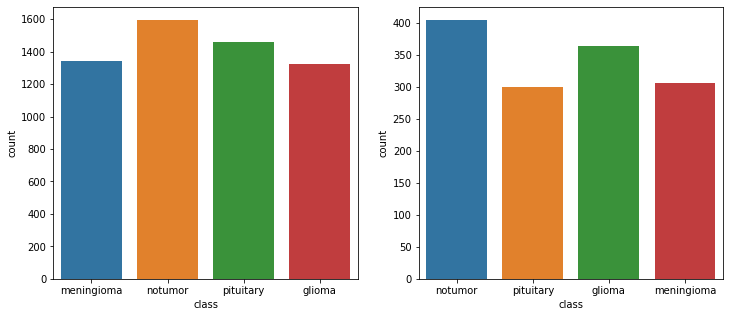

In [10]:
figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in train set: ", sum(train_quantity.values()))
print("Number of images in test set: ", sum(test_quantity.values()))

plt.show()

In [11]:
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

In [12]:
labels

['meningioma', 'notumor', 'pituitary', 'glioma']

In [13]:
# Importing dataset
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(HEIGHT, WIDTH))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(root_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(HEIGHT, WIDTH))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 364/364 [00:01<00:00, 210.92it/s]


In [14]:
# Convert image to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train[:5]

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [1, 1, 1],
         ...,
         [1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]],

        [[1, 1, 1],
         [3, 3, 3],
         [2, 2, 2],
         ...,
         [2, 2, 2],
         [3, 3, 3],
         [1, 1, 1]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [3, 3, 3],
         [3, 3, 3],
         [3, 3, 3]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [3, 3, 3],
         [1, 1, 1],
         [1, 1, 1]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [15]:
#Scale the data
X_train=X_train/255
X_test=X_test/255

In [16]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [17]:
# Encode the target labels
# Label Encoding 
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Fit and transform y_train
y_train_encoded = le.fit_transform(y_train)

# Convert encoded labels to categorical
y_train = tf.keras.utils.to_categorical(y_train_encoded)


In [18]:
y_train.shape

(5712, 4)

In [19]:
# Fit and transform y_train
y_test_encoded = le.fit_transform(y_test)

# Convert encoded labels to categorical
y_test = tf.keras.utils.to_categorical(y_test_encoded)

In [20]:
y_test.shape

(1375, 4)

In [21]:
# Create an ImageDataGenerator object
data_gen = ImageDataGenerator(
    fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)

# Use the flow_from_directory method to generate batches of images from our directory
train_ds = data_gen.flow(
    X_train, y_train,  # directory containing the training images
    batch_size=BATCH_SIZE,  # number of images per batch
    subset='training',
    shuffle=True
)

In [22]:
val_ds = data_gen.flow(
    X_train,y_train,  # directory containing the training images
    batch_size=BATCH_SIZE,  # number of images per batch
    subset='validation',
    shuffle=True
)

In [23]:
data_gen2 = ImageDataGenerator()

test_ds = data_gen2.flow(
    X_test, y_test,  # directory containing the test images
    batch_size=BATCH_SIZE,  # number of images per batch
    shuffle=False
)

In [24]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1
    
class_mapping

{0: 'meningioma', 1: 'notumor', 2: 'pituitary', 3: 'glioma'}

In [25]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(test_Folder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(test_Folder)):
        if folder == '.DS_Store':
            pass
        else:
            image_ids = os.listdir(os.path.join(test_Folder,folder))
            for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

                display = cv2.imread(os.path.join(test_Folder,folder,image_ids[j]),1)
                display = cv2.resize(display, (HEIGHT, WIDTH))/255.0
                plt.axis('off')
                ax1[axs].imshow(display)
                title = 'True: '+folder
                if(predict_using_model):
                    result = predict_using_model.predict(np.array([display]))
                    #print(result)
                    acc = str(round(np.max(result)*100, 3))
                    predicted_classname = class_mapping[np.argmax(result)]
                    title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
                ax1[axs].set_title(title)
                axs=axs+1

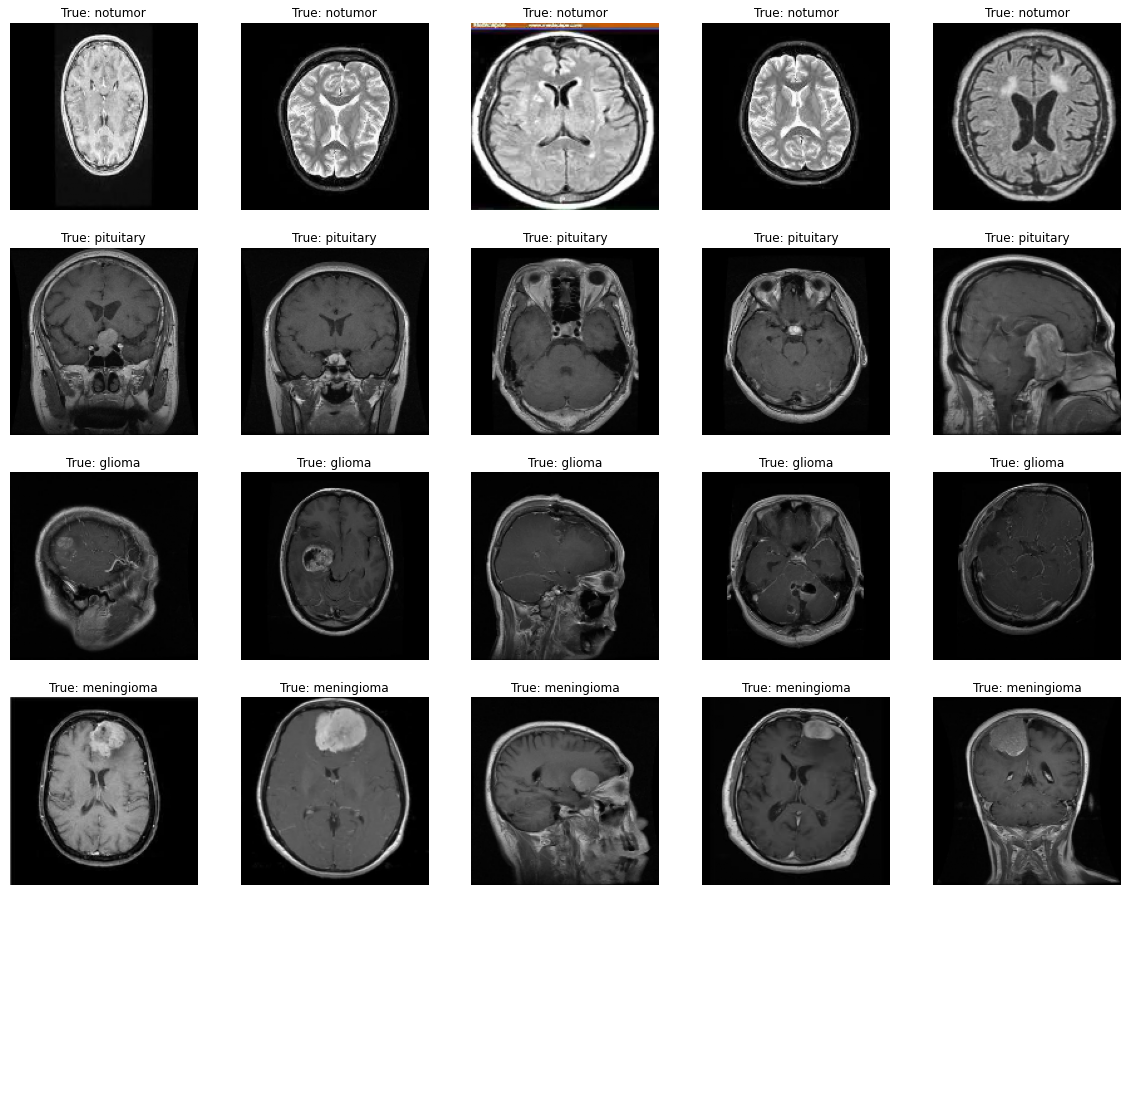

In [26]:
show_few_images(5)

In [27]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32, 4)


In [28]:
tf.keras.backend.clear_session()

**MODEL 1 - CONVOLUTIONAL NEURAL NETWORK**

In [30]:
model = Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(HEIGHT, WIDTH, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation="softmax"))    

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [33]:
# Create callbacks
modelsavepath = root_path+'/BTMC_CNN_Model.h5'
logsavepath = root_path+'/BTMC_CNN_Modellog.log'
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(filepath=modelsavepath, save_best_only=True,monitor='val_loss',mode='min',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10,mode='auto',min_delta=0.0001)
csvlogger = CSVLogger(logsavepath, separator=',', append=False),
callbacks=[early_stopping, model_checkpoint, reduce_lr,csvlogger]

In [34]:
history = model.fit(train_ds,
                           epochs=60, 
                           verbose=1, 
                           validation_data = val_ds,
                           callbacks=callbacks)

Epoch 1/60
161/161 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.5997
Epoch 1: val_loss improved from inf to 0.63288, saving model to /content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI/BTMC_CNN_Model.h5
161/161 [==============================] - 33s 166ms/step - loss: 0.9234 - accuracy: 0.5997 - val_loss: 0.6329 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 2/60
161/161 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7654
Epoch 2: val_loss improved from 0.63288 to 0.45772, saving model to /content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI/BTMC_CNN_Model.h5
161/161 [==============================] - 26s 164ms/step - loss: 0.5991 - accuracy: 0.7654 - val_loss: 0.4577 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 3/60
161/161 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.8152
Epoch 3: val_loss did not improve from 0.45772
161/161 [==============================] - 27s 16

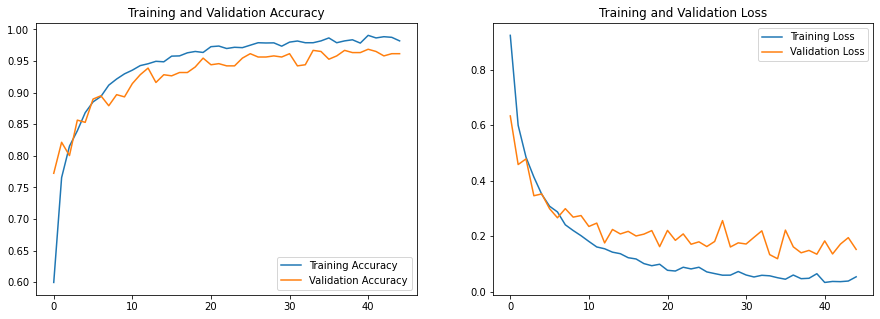

In [35]:

# Access the trained model
model = keras.models.load_model(modelsavepath, compile=False)

history = pd.read_csv(logsavepath, sep=',', engine='python')

############### ########## ####### #######

acc=history['accuracy']
val_acc=history['val_accuracy']


loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
43/43 [==============================] - 1s 15ms/step - loss: 0.1305 - accuracy: 0.9600
test loss: 0.13, test acc: 0.96


1/1 [==============================] - 0s 53ms/step


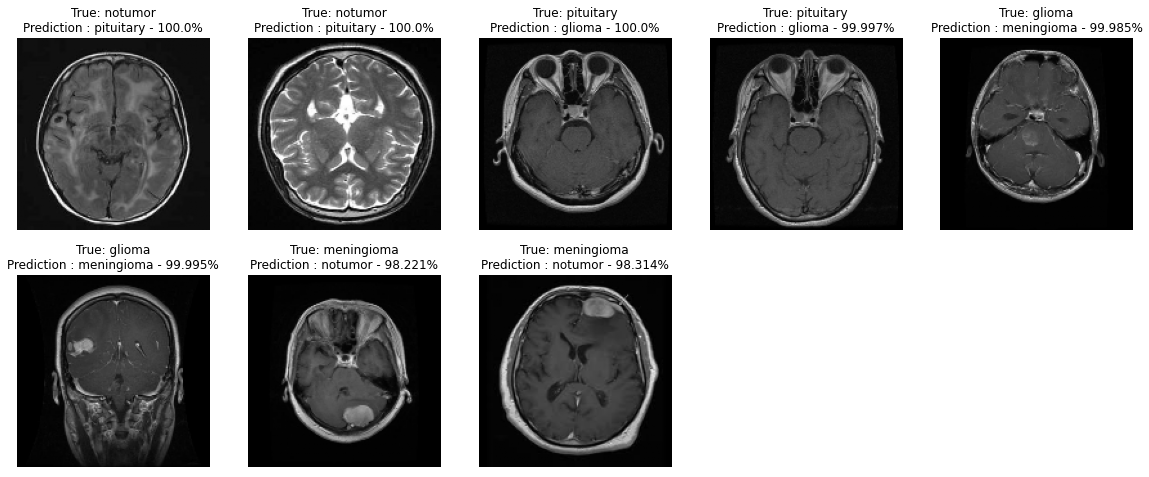

In [52]:
show_few_images(2, model)

In [43]:
labels_pred= model.predict(test_ds)

43/43 [==============================] - 1s 10ms/step


In [44]:
y_pred = tf.argmax(labels_pred, axis=1)

In [45]:
y_true = tf.argmax(y_test, axis = 1)

In [46]:
print(classification_report(y_true, y_pred, target_names=labels))
plt.show()

              precision    recall  f1-score   support

  meningioma       0.98      0.91      0.94       364
     notumor       0.90      0.96      0.93       306
   pituitary       0.97      1.00      0.98       405
      glioma       0.99      0.97      0.98       300

    accuracy                           0.96      1375
   macro avg       0.96      0.96      0.96      1375
weighted avg       0.96      0.96      0.96      1375



In [47]:
# Function to plot our models confusion matrix
def plot_confusion_matrics(model, y_pred, y_true):
    
    # confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    # Dataframe to store values  {0: 'meningioma', 1: 'notumor', 2: 'pituitary', 3: 'glioma'}
    df_cm = pd.DataFrame(matrix, index = ['Meningioma', 'Notumor','Pituitary','Glioma'],
                                columns = ['Meningioma', 'Notumor','Pituitary','Glioma'])
    plt.figure(figsize = (12,8))
    #plot confusion matrix
    sns.heatmap(df_cm,
                annot=True,
                cmap='Greens',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05)
    plt.xlabel('Predicted values', fontsize = 20)
    plt.ylabel('True values', fontsize = 20)
    plt.show()

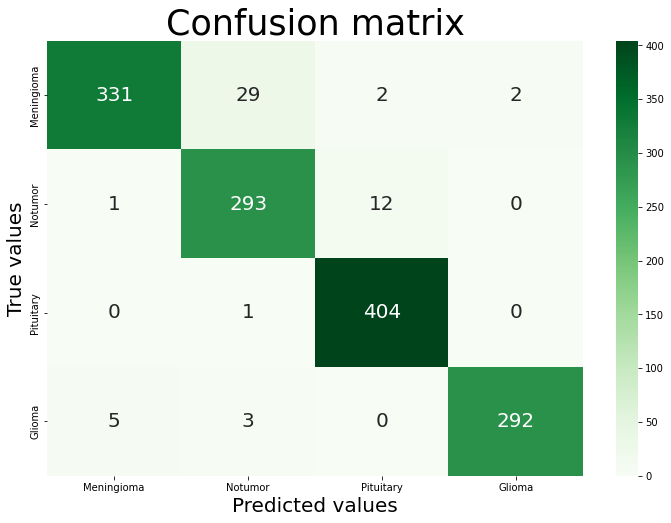

In [48]:
plot_confusion_matrics(model, y_pred, y_true)

In [53]:
tf.keras.backend.clear_session()

**TRANSFER LEARNING (USING VGG16)**

In [54]:
def create_model(input_shape=(150, 150, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.

    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
   
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
vgg16_final_model = create_model(fine_tune=0)
vgg16_final_model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [55]:
# Create callbacks
modelsavepath = root_path+'/VGG16_CNN_Model.h5'
logsavepath = root_path+'/VGG16_CNN_Modellog.log'
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint(filepath=modelsavepath, save_best_only=True,monitor='val_loss',mode='min',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5,mode='auto',min_delta=0.0001)
csvlogger = CSVLogger(logsavepath, separator=',', append=False),
callbacks=[early_stopping, model_checkpoint, reduce_lr,csvlogger]

In [56]:
VGG_history = vgg16_final_model.fit(train_ds,
                           epochs=60, 
                           verbose=1, 
                           validation_data = val_ds,
                           callbacks=callbacks)

Epoch 1/60
161/161 [==============================] - ETA: 0s - loss: 0.7317 - accuracy: 0.7329
Epoch 1: val_loss improved from inf to 0.41328, saving model to /content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI/VGG16_CNN_Model.h5
161/161 [==============================] - 38s 219ms/step - loss: 0.7317 - accuracy: 0.7329 - val_loss: 0.4133 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 2/60
161/161 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8160
Epoch 2: val_loss improved from 0.41328 to 0.37451, saving model to /content/drive/MyDrive/Data Science/Data Science/BrainTumorMRI/BrainTumorMRI/VGG16_CNN_Model.h5
161/161 [==============================] - 32s 198ms/step - loss: 0.4896 - accuracy: 0.8160 - val_loss: 0.3745 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 3/60
161/161 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8409
Epoch 3: val_loss improved from 0.37451 to 0.31639, saving model to /content/drive/MyDrive/Dat

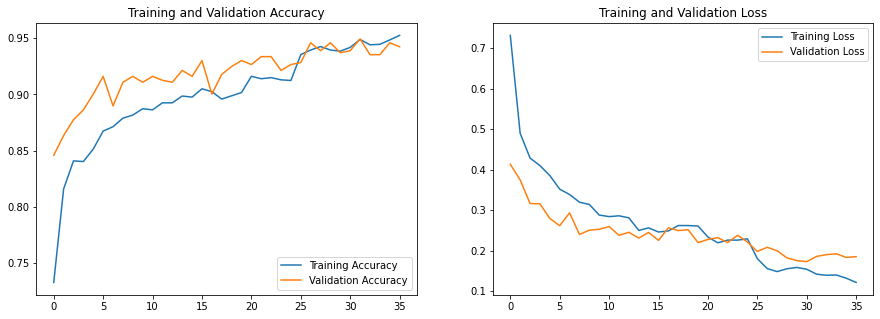

In [57]:
############ load trained model ################
vgg16_model = keras.models.load_model(modelsavepath, compile=False)

history = pd.read_csv(logsavepath, sep=',', engine='python')

############### ########## ####### #######

acc=history['accuracy']
val_acc=history['val_accuracy']


loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
vgg16_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
43/43 [==============================] - 1s 12ms/step - loss: 0.1305 - accuracy: 0.9600
test loss: 0.13, test acc: 0.96


1/1 [==============================] - 0s 16ms/step


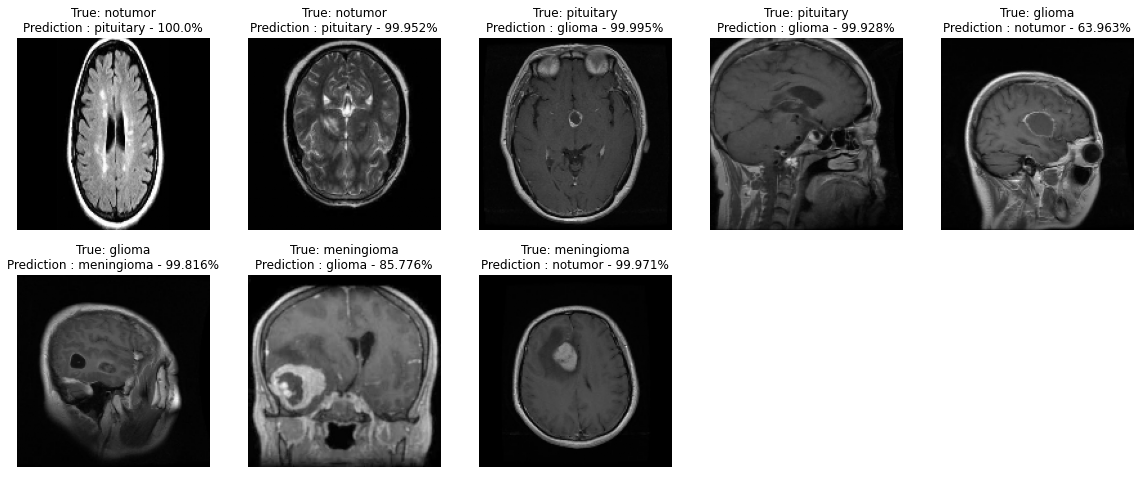

In [59]:
show_few_images(2, vgg16_model)

In [60]:
labels_pred= vgg16_model.predict(test_ds)

43/43 [==============================] - 5s 112ms/step


In [61]:
y_pred = tf.argmax(labels_pred, axis=1)

In [62]:
y_true = tf.argmax(y_test, axis = 1)

In [63]:
print(classification_report(y_true, y_pred, target_names=labels))
plt.show()

              precision    recall  f1-score   support

  meningioma       0.99      0.81      0.89       364
     notumor       0.83      0.88      0.86       306
   pituitary       0.96      1.00      0.98       405
      glioma       0.88      0.99      0.93       300

    accuracy                           0.92      1375
   macro avg       0.92      0.92      0.92      1375
weighted avg       0.92      0.92      0.92      1375



In [64]:
# Function to plot our models confusion matrix
def plot_confusion_matrics(model, y_pred, y_true):
    
    # confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    # Dataframe to store values  {0: 'meningioma', 1: 'notumor', 2: 'pituitary', 3: 'glioma'}
    df_cm = pd.DataFrame(matrix, index = ['Meningioma', 'Notumor','Pituitary','Glioma'],
                                columns = ['Meningioma', 'Notumor','Pituitary','Glioma'])
    plt.figure(figsize = (12,8))
    #plot confusion matrix
    sns.heatmap(df_cm,
                annot=True,
                cmap='Greens',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 35, y=1.05)
    plt.xlabel('Predicted values', fontsize = 20)
    plt.ylabel('True values', fontsize = 20)
    plt.show()

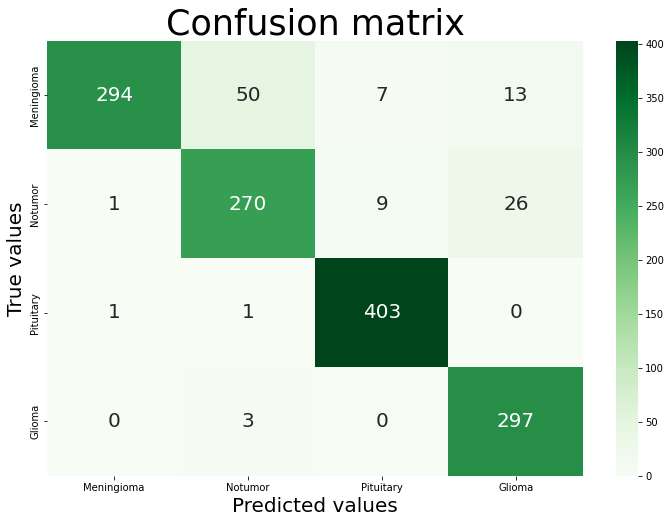

In [65]:
plot_confusion_matrics(vgg16_model, y_pred, y_true)